# Quickstart Example with Basic Synthetic Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing the logged dataset collected on an basic environment.

This example on consists of the following 3 cases:
1. Discrete Action Case
2. Continuous Action Case
3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [3]:
# import SCOPE-RL modules
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [4]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# version
print(scope_rl.__version__)

0.0.0


In [6]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 0. Description of Synthetic Basic Simulation Environment
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Synthetic
In Synthetic , the objective of the RL agent is to maximize reward

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.

Let's see how it works!

In [7]:
# setup environment
env = BasicEnv(random_state=random_state)

In [8]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
        )
    ),
    name="random",
)

In [9]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [10]:
# state 
print(obs.shape)
print(obs)

(5,)
[-0.37164978 -0.49943402  0.36963097 -0.28399277 -0.62862005]


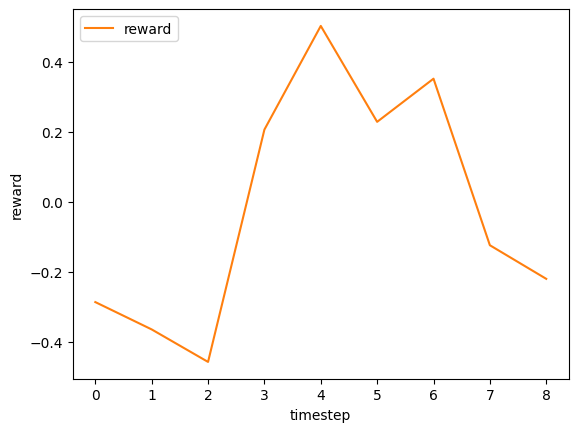

In [11]:
# let's visualize the transition of the reward
# our goal is to obtain a policy (or an agent) that maximizes the reward
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a behavior policy in the case of discrete action.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [12]:
# standardized environment for discrete action
env = gym.make("BasicEnv-discrete-v0")

In [13]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [14]:
# learn a base deterministic policy for data collection
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [16]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [15]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochastic behavior policy.

We use epsilon-greedy policy to collect logged data using `EpsilonGreedyHead`, where the behavior policy greedily takes an action chosen by the deterministic policy with probability $1 - \epsilon$ and takes an action randomly with probability $\epsilon$ as follows.

$$\pi(a | s) := (1 - \epsilon) * \pi_{\mathrm{det}}(a | s) + \epsilon / |\mathcal{A}|,$$

where $a \in \mathcal{A}$ is an action, $s \in \mathcal{S}$ is a state, and $\pi$ is a stochastic policy defined with the (deterministic) behavior policy $\pi_{\mathrm{det}}$.

`SyntheticDataset` has the following arguments:
- `env`: Basic synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

In [16]:
# convert the base ddqn policy into a stochastic data collection policy
from scope_rl.policy import EpsilonGreedyHead

behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [ ]:
# collect data
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [20]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.00305434,  0.25886564,  0.94683458, -0.18441597, -0.04974207],
        [ 0.09209668,  0.18060315, -0.96557628, -0.16297735,  0.00123719],
        ...,
        [-0.32659665, -0.4457801 ,  0.12418311, -0.55321285,  0.61085909],
        [ 0.91297429, -0.08570925,  0.24184222, -0.15626001,  0.27609242],
        [-0.38500003,  0.06259195,  0.51752316, -0.76154405,  0.00881301]]),
 'action': array([6, 1, 5, ..., 8, 6, 5]),
 'reward': array([ 0.85571015, -0.27916946,  0.43932507, ...,  0.03190668,
         0.79813161,  0.60196688]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.73, 0.03, 0.73, ..

### 1.2. Softmax behavior policy
We can also use `SoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of a given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as:

$$\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)},$$

where $A$ indicates the set discrete actions and $\tau$ is an inverse temperature parameter.

In [21]:
# convert base ddqn policy into a stochastic data collection policy
from scope_rl.policy import SoftmaxHead

behavior_policy = SoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [22]:
# collect data
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.08760293,  0.77361897,  0.10330632,  0.50462601, -0.3584966 ],
        [-0.00979766, -0.05763496, -0.91580661, -0.3969812 ,  0.01692308],
        ...,
        [ 0.02753215, -0.11163809, -0.42714171,  0.21239973, -0.87132958],
        [-0.83875254, -0.49579421,  0.21456818, -0.06545365,  0.01893677],
        [-0.10541374, -0.47604766,  0.73137365, -0.20352238,  0.43120505]]),
 'action': array([3, 2, 9, ..., 6, 5, 5]),
 'reward': array([ 0.59952345, -0.06572189,  0.65681124, ...,  0.46213711,
         0.48979255,  0.44161552]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.10093084, 0.081964

For offline RL and OPE procedures, please refer to [examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb).

For more advanced topic in OPE and OPS, please refer to [examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb).

## 2. Continuous Action Space
We also describe the case where a continuous behavior policy is used. \
Here, we first learn a base deterministic policy in a similar manner with the discrete action case.

In [24]:
# standardized environment for continuous action
env = gym.make("BasicEnv-continuous-v0")

In [25]:
# for api compatibility to d3rlpy
env_ = OldGymAPIWrapper(env)

In [26]:
# learn base deterministic policy for data collection
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)

In [ ]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [28]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [29]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2023-06-01 20:33:29 [warning  ] Parameters will be reinitialized.


### 2.1. Gaussian behavior policy

Then, we convert a deterministic policy (i.e., greedy action choice of sac policy) into a stochastic policy. 

As the action space of `BasicEnv` is bounded, we use `TruncatedGaussianHead`. \
Given the deterministic action $\pi(s)$, this behavior policy samples actions from a truncated gaussian distribution as:

$$a \sim Truncnorm(\pi(s), \sigma),$$

where $\sigma$ indicates the noise level. 

Note that, when action space is not bounded, we can use `GaussianHead` in a similar manner.

In [30]:
# convert base ddqn policy into a stochastic data collection policy
from scope_rl.policy import TruncatedGaussianHead

behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # lower bound of the action space
    maximum=env.action_space.high,  # upper bound of the action space
    sigma=np.array([1.0]),  # noise level of a gaussian distribution
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [31]:
# collect data
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 3,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.05891126, -0.06555765,  0.98600333,  0.12112277,  0.07320091],
        [-0.18194331, -0.00513215,  0.77436482,  0.00337057,  0.6059852 ],
        ...,
        [-0.16663302,  0.43736381,  0.12402931,  0.25500405,  0.83698029],
        [ 0.4763488 ,  0.65508546, -0.40002208, -0.36545688, -0.22445147],
        [-0.00178433, -0.52876061,  0.28876333, -0.7751539 ,  0.19016098]]),
 'action': array([[-0.06317163, -0.62054752,  0.10895855],
        [ 0.88734042, -0.8164349 , -0.89030074],
        [ 0.92437659,  0.50590528, -0.07130546],
        ...,
        [ 0.99385417,  0.41575683, -0.35725269],
        [ 0.24626717, -0.73723776,  0.20190287],
        [ 0.62388291,  0.04214697,

## 3. Collecting Logged Datasets with Multiple Behavior Policies and Random Seeds
Finally, we show how to collect logged data by several behavior policies and random seeds.

We show the example in the discrete action case, but the continuous action case can also be handled in a simmilar manner.

In [33]:
# standardized environment for discrete action
env = gym.make("BasicEnv-discrete-v0")

In [34]:
# define several behavior policies
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,  # probability of taking random action
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,  # probability of taking random action
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,  # probability of taking random action
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [35]:
# initialize the dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
logged_datasets = dataset.obtain_episodes(
    behavior_policies=behavior_policies,
    n_datasets=2,  # number of random states
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [37]:
logged_dataset = logged_datasets.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.00305434,  0.25886564,  0.94683458, -0.18441597, -0.04974207],
        [-0.13005656, -0.04117723,  0.18071338, -0.53347445,  0.81494626],
        ...,
        [-0.08478852, -0.3479735 ,  0.75742481, -0.24848499,  0.48609486],
        [ 0.32137867,  0.1693463 ,  0.23226263,  0.01125472,  0.90220008],
        [ 0.18166203,  0.18438391,  0.51489873, -0.81376705,  0.07525929]]),
 'action': array([6, 6, 6, ..., 8, 6, 6]),
 'reward': array([ 0.85571015,  0.80607969,  0.9978151 , ..., -0.17080268,
         0.89288442,  0.90787381]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.91, 0.91, 0.91, ..

For offline RL and OPE procedures, please refer to [examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb). 

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.